# Listings

In [195]:
import pandas as pd

df_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/listings.csv.gz', compression='gzip')
df_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/listings.csv.gz', compression='gzip')
df_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/listings.csv.gz', compression='gzip')
df_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/listings.csv.gz', compression='gzip')
df_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/listings.csv.gz', compression='gzip')
df_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/listings.csv.gz', compression='gzip')

df_original_listings = pd.concat([df_2020_03, df_2019_18, df_2018_10, df_2017_10, df_2016_09, df_2015_10]).drop_duplicates('id')
# df_original_listings = pd.concat([df_2020_03, df_2019_18, df_2018_10, df_2017_10, df_2016_09]).drop_duplicates('id')
# df_original_listings = pd.concat([df_2020_03, df_2019_18]).drop_duplicates('id')
print('Len total =', len(df_original_listings))

df_listings = df_original_listings.copy()
df_listings = df_listings.replace('nan', '', regex=True)
df_listings['summary'] = df_listings['summary'].astype(str)
df_listings['space'] = df_listings['space'].astype(str)
df_listings['description'] = df_listings['description'].astype(str)
df_listings['neighborhood_overview'] = df_listings['neighborhood_overview'].astype(str)
df_listings['host_neighbourhood'] = df_listings['host_neighbourhood'].astype(str)
df_listings['neighbourhood_cleansed'] = df_listings['neighbourhood_cleansed'].astype(str)
df_listings['notes'] = df_listings['notes'].astype(str)
df_listings['review_scores_rating'] = df_listings['review_scores_rating'].astype(float)
df_listings = df_listings[df_listings['review_scores_rating'].notna()]
print(len(df_listings))
df_listings['review_scores_rating']

Len total = 12480
9684


0        99.0
1        95.0
2        96.0
3        93.0
4        95.0
        ...  
2552     96.0
2554     99.0
2555     99.0
2556    100.0
2557     87.0
Name: review_scores_rating, Length: 9684, dtype: float64

In [196]:
from collections import Counter
from itertools import chain
import itertools
import string
import re
import spacy

# Download the natural language dataset for english, if this is the first run
# !python -m spacy download en_core_web_sm

# Load spacy
nlp = spacy.load('en_core_web_sm')

# Add in common words that occurr in all listings, that really don't mean anything useful here
nlp.Defaults.stop_words |= {'many', 'great', 'nearby', 'short', 'major', 'north', 'south', 'east', 'west', 'easy', 'true', 'local', 'public', 'mi', 'several', 'such', 'main', 'other'}

# Creates a Counter of adjectives used in the "neighborhood overview" field of all listings
# within the neighborhood name provided. 
def get_neighborhood_adjectives(name):
  
  # List of the "neighborhood_overview" field for all listings for this neighborhood
  overviews = df_listings.loc[df_listings['neighbourhood_cleansed'] == name]['neighborhood_overview']
  
  list_overviews = '  '.join([overview for overview in overviews])
    
  # Combine all overviews into one, and load it into spacy
  text = nlp(list_overviews)
  
  # Get the adjectives
  adjectives = [token.lemma_ for token in text if token.pos_ == "ADJ" and not token.is_stop]
  
  # Count the adjectives
  counter = Counter(adjectives)
  
  # Remove pronoun forms
  counter.pop('-PRON-', None)
  
  return (len(overviews), counter)

  
# north_end = get_neighborhood_adjectives('North End')
# print('Listings in north end:', north_end[0])
# print('North end is:', north_end[1])

True


In [197]:
# for neighborhood in df_listings['neighbourhood_cleansed'].unique():
#     ads = get_neighborhood_adjectives(neighborhood)
#     print(neighborhood, ':', ads[0])
#     print(neighborhood, 'is:', ads[1].most_common(5))

# Reviews

In [198]:
import pandas as pd

reviews_2020_03 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2020-03-16/data/reviews.csv.gz', compression='gzip')
# reviews_2019_18 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2019-10-18/data/reviews.csv.gz', compression='gzip')
# reviews_2018_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2018-10-11/data/reviews.csv.gz', compression='gzip')
# reviews_2017_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/reviews.csv.gz', compression='gzip')
# reviews_2016_09 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/reviews.csv.gz', compression='gzip')
# reviews_2015_10 = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/reviews.csv.gz', compression='gzip')

df_reviews = pd.concat([reviews_2020_03])
# df_reviews = pd.concat([reviews_2020_03, reviews_2019_18, reviews_2018_10, reviews_2017_10, reviews_2016_09, reviews_2015_10])
df_reviews['comments'] = df_reviews['comments'].astype(str)
print('Len total =', len(df_reviews))

Len total = 154464


# Vibe Factor Calculations

In [310]:
# Load spacy
import spacy
nlp = spacy.load('en_core_web_sm')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Calculates the neighborhood accuracy statistic for a listing
# Neighborhood accuracy is the dot product between the neighborhood description
# and the reviews left for the place. This metric is greatest when the experience
# of the visitors most matched the vibe that was portrayed by the listing.

# Neighborhood accuracy is calculated as the sum of the number of adjectives that appear 
# in both the neighborhood description and in the reviews for a listing,
# weighted by the frequency by which those adjectives occur in all 
# neighborhood descriptions within that neighborhood.

# calc_neighborhood_accuracy(comments_list) takes in a list of strings as the comments
# for that listing. It returns a scalar neighborhood accuracy score.
def calc_neighborhood_accuracy(neighborhood_adjectives, neighborhood_frequencies, comments_list):
  neighborhood_accuracy = 0

  # Comments, excluding punctuation and special characters
  listing_comments = re.sub('[^\w\s]+', '', ' '.join(comments_list)).split()
  
  # Count up the frequencies of these words
  comment_freq = Counter(listing_comments)
  comment_words = list(comment_freq.keys())

  # Dot product time doo doo doo doo doo
  for i in range(len(neighborhood_adjectives)):
    if (neighborhood_adjectives[i] in comment_words):
      neighborhood_accuracy += neighborhood_frequencies[i] * comment_freq[neighborhood_adjectives[i]]

  neighborhood_accuracy /= len(comments_list)

  return neighborhood_accuracy

WALKABILITY_WORDS = ["transit", "train", "subway", "T", "bus", "ride", "walk", "walking", "walkable"]
TRANQUILITY_WORDS = ["quiet", "peace", "peaceful", "pleasant", "nice"]

# Calculates the mean sentiment of all reviews for a listing.
def calc_happiness(comments_list):  
  all_comments = '  '.join(comments_list)
  
  happiness = analyser.polarity_scores(all_comments)['compound']
  return happiness
  
# Calculates the frequency of words within word list appearing in a comments list
def calc_word_freq(comments_list, word_list):
  total_count = 0
  len_total = 0
  
  # Comments, excluding punctuation and special characters
  listing_comments = re.sub('[^\w\s]+', '', ' '.join(comments_list)).split()

  comment_freq = Counter(listing_comments)
  comment_words = list(comment_freq.keys())

  for word in comment_words:
    len_total += comment_freq[word]
    if word in word_list:
      total_count += comment_freq[word]

  # Normalized by total number of words
  return total_count / len_total


In [309]:
calc_happiness(['The movie sucked. That cake is the shit!'])
# %timeit calc_word_freq(['I really enjoyed walking', 'Walkability is insane', 'Can walk anywhere you want'], ["transit", "train", "subway", "T", "bus", "ride", "walk", "walking", "walkable"])

0.3164

# Generate all data

In [350]:
def gen_data():
  vibedict = []
  for neighborhood in df_listings['neighbourhood_cleansed'].unique():
    
    # Primary adjectives and their frequencies, used by all listings within to describe this neighborhood
    neighborhood_adjectives = get_neighborhood_adjectives(neighborhood)[1]
    adjectives = list(neighborhood_adjectives)
    frequencies = [neighborhood_adjectives[adjective] for adjective in adjectives]

    count = 1
    listings = df_listings.loc[df_listings['neighbourhood_cleansed'] == neighborhood]['id']
    total_num = len(listings)

    print('Calculating vibes for', len(listings), 'listings in', neighborhood)

    # for each listing within this neighborhood
    for listing_id in listings:
      
      description = df_listings.loc[df_listings['id'] == listing_id]['description'].values[0]
      n_overview = df_listings.loc[df_listings['id'] == listing_id]['neighborhood_overview'].values[0]
            
      # List of comments for that listing
      comments_list = df_reviews.loc[df_reviews['listing_id'] == listing_id]['comments'].tolist()
      num_comments = len(comments_list)
      if num_comments == 0:
        continue

#       print('Vibe calculation for listing', listing_id, 'with', num_comments, 'comments')
        
      # Neighborhood accuracy metric ("Honesty")
      honesty = calc_neighborhood_accuracy(adjectives, frequencies, comments_list)

      # Average sentiment of reviews + Average rating ("Happiness")
      happiness = df_listings.loc[df_listings['id'] == listing_id]['review_scores_rating'].values[0]
#       + calc_happiness(comments_list)
      
      # Number of ratings ("Liveliness")
      liveliness = len(comments_list)
      
      # Walkability + Transit, combined into one factor ("Walkability")
      walkability = calc_word_freq(comments_list + [description, n_overview], WALKABILITY_WORDS)
      
      # Tranquility + Peacefulness, combined into one factor ("Peacefulness")
      peacefulness = calc_word_freq(comments_list + [description, n_overview], TRANQUILITY_WORDS)
      
      # Add this listing and its metrics to the dictionary
      vibedict.append({'listing_id': listing_id,
                       'lat': df_listings.loc[df_listings['id'] == listing_id]['latitude'].values[0],
                       'lon': df_listings.loc[df_listings['id'] == listing_id]['longitude'].values[0],
                       'honesty': honesty,
                       'happiness': happiness,
                       'liveliness': liveliness,
                       'walkability': walkability,
                       'peacefulness': peacefulness})

      count = count + 1

  vibetable = pd.DataFrame(columns=['listing_id', 'lat', 'lon', 'honesty',  'happiness', 'liveliness', 'walkability', 'peacefulness'])
  vibetable = vibetable.append(vibedict, ignore_index=True)
  return vibetable

In [351]:
vibetable = gen_data()

Calculating vibes for 567 listings in East Boston
Calculating vibes for 534 listings in Roxbury
Calculating vibes for 631 listings in Downtown
Calculating vibes for 758 listings in Back Bay
Calculating vibes for 894 listings in Dorchester
Calculating vibes for 720 listings in South End
Calculating vibes for 347 listings in North End
Calculating vibes for 299 listings in Charlestown
Calculating vibes for 735 listings in Jamaica Plain
Calculating vibes for 717 listings in Allston
Calculating vibes for 483 listings in South Boston
Calculating vibes for 96 listings in Bay Village
Calculating vibes for 572 listings in Brighton
Calculating vibes for 109 listings in West Roxbury
Calculating vibes for 165 listings in Roslindale
Calculating vibes for 471 listings in Beacon Hill
Calculating vibes for 273 listings in Mission Hill
Calculating vibes for 160 listings in South Boston Waterfront
Calculating vibes for 595 listings in Fenway
Calculating vibes for 156 listings in West End
Calculating vib

In [352]:
import numpy as np

scaled_table = vibetable.copy()

scaled_table['honesty'] = (vibetable['honesty'] - np.quantile(vibetable['honesty'], 0.01)).clip(lower=0)
scaled_table['honesty'] = (scaled_table['honesty'] / np.quantile(scaled_table['honesty'], 0.99)).clip(upper=1)

scaled_table['happiness'] = (vibetable['happiness'] - np.quantile(vibetable['happiness'], 0.01)).clip(lower=0)
scaled_table['happiness'] = (scaled_table['happiness'] / np.quantile(scaled_table['happiness'], 0.99)).clip(upper=1)

scaled_table['liveliness'] = (vibetable['liveliness'] - np.quantile(vibetable['liveliness'], 0.0000001)).clip(lower=0)
scaled_table['liveliness'] = (scaled_table['liveliness'] / np.quantile(scaled_table['liveliness'], 0.99)).clip(upper=1)

scaled_table['walkability'] = (vibetable['walkability'] - np.quantile(vibetable['walkability'], 0.01)).clip(lower=0)
scaled_table['walkability'] = (scaled_table['walkability'] / np.quantile(scaled_table['walkability'], 0.985)).clip(upper=1)

scaled_table['peacefulness'] = (vibetable['peacefulness'] - np.quantile(vibetable['peacefulness'], 0.01)).clip(lower=0)
scaled_table['peacefulness'] = (scaled_table['peacefulness'] / np.quantile(scaled_table['peacefulness'], 0.99)).clip(upper=1)


In [353]:
scaled_table.to_json("dist/data/scaled_table.json", orient='index')

(array([ 53.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   5.,   0.,   2.,
          1.,  16.,   1.,   0.,   1.,  12.,   2.,   3.,   0.,   9.,   6.,
          7.,   3.,   0., 103.,  11.,  14.,  28.,   0.,  25.,  29.,  34.,
         63.,  70.,   0.,  64., 162., 102.,   0., 124., 176., 161., 182.,
          0., 259., 246., 257., 204., 553.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

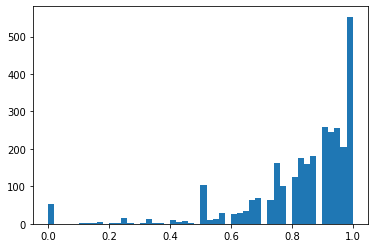

In [354]:
import matplotlib.pyplot as plt
plt.hist(scaled_table['happiness'], bins=50)

In [296]:
# For reading in already calculated happiness data

# import pandas as pd
# happiness = pd.read_json('dist/data/vibetable.json', orient='index')['happiness']

# scaled_table['happiness'] = (happiness - np.quantile(happiness, 0.01)).clip(lower=0).replace(1, 0, inplace=False)

In [341]:
df_listings.loc[df_listings['id'] == 1651]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
